In [24]:
## load packages
suppressPackageStartupMessages({
  library(ComplexHeatmap)
  library(emmeans)
  library(ggh4x)
  library(ggpattern)
  library(ggplotify)
  library(ggsignif)
  library(Hmisc)
  library(janitor)
  library(patchwork)
  library(phyloseq)
  library(scales)
  library(tidyverse)
})

In [25]:
## paths to directories
repo <- file.path("/Users/abandla/Desktop/2_research/1_manuscripts/2_2020_brunei_peat_fire/")
data <- file.path(repo, "1_data")
figures <- file.path(repo, "3_figures")

In [26]:
## set global theme options for plots
btp_theme <- theme(
  axis.text = element_text(size = 16, color = "black"),
  axis.text.y = element_text(margin = margin(0, 10, 0, 10)),
  axis.text.x = element_text(margin = margin(10, 0, 10, 0)),
  axis.title = element_text(size = 18),
  axis.ticks.length = unit(.25, "cm"),
  panel.border = element_rect(linewidth = 0.5, fill = NA),
  panel.background = element_rect(fill = NA),
  panel.grid = element_blank(),
  legend.text = element_text(size = 16),
  legend.title = element_text(size = 18),
  legend.key = element_rect(fill = NA),
  legend.background = element_rect(fill = NA)
)

In [27]:
## import phyloseq object
btp_fire_ps <- readRDS(file.path(data, "3_phyloseq", "2020_btp_fire_ps.rds"))
btp_fire_ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3928 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 3928 taxa by 7 taxonomic ranks ]

In [28]:
## import nsti data
btp_nsti <- read.table(
  file.path(data, "5_picrust2", "2020_btp_fire_16S_nsti.tsv"),
  sep = "\t",
  header = TRUE
) %>%
  filter(NSTI <= 2)

In [30]:
## import PICRUST2 results
## ASVs with methanogenesis modules ≥0.75 completeness
btp_ko_methanogenesis_modules <- read.table(
    file.path(data, "5_picrust2", "2020_btp_ko_methanogenesis.tsv"),
    sep = "\t",
    header = TRUE
) %>%
  clean_names %>%
  filter(genome_name %in% pull(btp_nsti, ASV))

In [31]:
## abundance of methanogenic archaea
## 72 ASVs from class Bathyarchaeia
## 8/72 ASVs ~11% predicted to be methanogens
methanogen_abundance <- btp_fire_ps %>%
  subset_taxa(., Kingdom == "Archaea") %>%
  transform_sample_counts(., function(x) x / sum(x)) %>%
  psmelt %>%
  filter(OTU %in% pull(distinct(btp_ko_methanogenesis_modules, genome_name))) %>%
  group_by(Sample, psf_type, depth) %>%
  reframe(Abundance = round((sum(Abundance) * 100), 2))

In [32]:
## ASV-pathway map
asv_pathway_map <- btp_ko_methanogenesis_modules %>%
  mutate(pathway = case_when(
    str_detect(module_name, "CO2") ~ "Hydrogenotrophic",
    str_detect(module_name, "acetate") ~ "Acetoclastic",
    TRUE ~ "Methylotrophic"
  )) %>%
  mutate(id = case_when(
    pathway == "Hydrogenotrophic" ~ 1,
    pathway == "Acetoclastic" ~ 2,
    TRUE ~ 3
  )) %>%
  distinct(genome_name, pathway, id) %>%
  pivot_wider(names_from = "pathway", values_from = "id", values_fill = 0)

In [34]:
asv_pathway_map %>%
  inner_join(
    tax_table(btp_fire_ps) %>%
      data.frame() %>%
      rownames_to_column("genome_name")
  )

Joining with `by = join_by(genome_name)`


genome_name,Hydrogenotrophic,Methylotrophic,Acetoclastic,Kingdom,Phylum,Class,Order,Family,Genus,Species
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ASV_1005,1,0,2,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobacterium,NA
ASV_1100,1,0,2,Archaea,Halobacterota,Methanomicrobia,Methanomicrobiales,Methanoregulaceae,Methanoregula,NA
ASV_1306,1,0,2,Archaea,Halobacterota,Methanomicrobia,Methanomicrobiales,Rice Cluster II,NA,NA
ASV_1478,1,0,2,Archaea,Halobacterota,Methanomicrobia,Methanomicrobiales,Rice Cluster II,NA,NA
ASV_205,1,0,2,Archaea,Halobacterota,Methanomicrobia,Methanomicrobiales,Rice Cluster II,NA,NA
ASV_2332,1,0,2,Archaea,Halobacterota,Methanomicrobia,Methanomicrobiales,Rice Cluster II,NA,NA
ASV_2422,1,0,2,Archaea,Halobacterota,Methanomicrobia,Methanomicrobiales,Rice Cluster II,NA,NA
ASV_2454,1,3,2,Archaea,Halobacterota,Methanosarcinia,Methanosarciniales,Methanosarcinaceae,Methanosarcina,NA
ASV_2658,1,0,2,Archaea,Halobacterota,Methanomicrobia,Methanomicrobiales,Methanoregulaceae,Methanoregula,NA


In [9]:
## abundance table for heatmap
methanogen_abundance_tab <- btp_fire_ps %>%
  subset_taxa(., Kingdom == "Archaea") %>%
  transform_sample_counts(., function(x) x / sum(x)) %>%
  psmelt %>%
  filter(OTU %in% pull(distinct(btp_ko_methanogenesis_modules, genome_name))) %>%
  group_by(psf_type, depth, OTU, Class) %>%
  reframe(Abundance = sqrt(mean(Abundance))) %>%
  arrange(psf_type, depth, Class) %>%
  group_by(psf_type, depth) %>%
  mutate(group = cur_group_id()) %>%
  ungroup %>%
  select(OTU, group, Abundance) %>% 
  mutate(OTU = parse_number(OTU)) %>%
  pivot_wider(names_from = OTU, values_from = Abundance) %>%
  column_to_rownames("group") %>%
  as.matrix

In [10]:
## extract class labels for heatmap
methanogen_class <- enframe(colnames(methanogen_abundance_tab), value = "ASV", name = NULL) %>%
  mutate(ASV = paste0("ASV_", ASV)) %>%
  inner_join(
    tax_table(btp_fire_ps) %>%
      data.frame() %>%
      rownames_to_column("ASV")
  ) %>%
  mutate(ASV = parse_number(ASV)) %>%
  mutate(Class = factor(Class)) %>%
  pull(Class)

Joining with `by = join_by(ASV)`


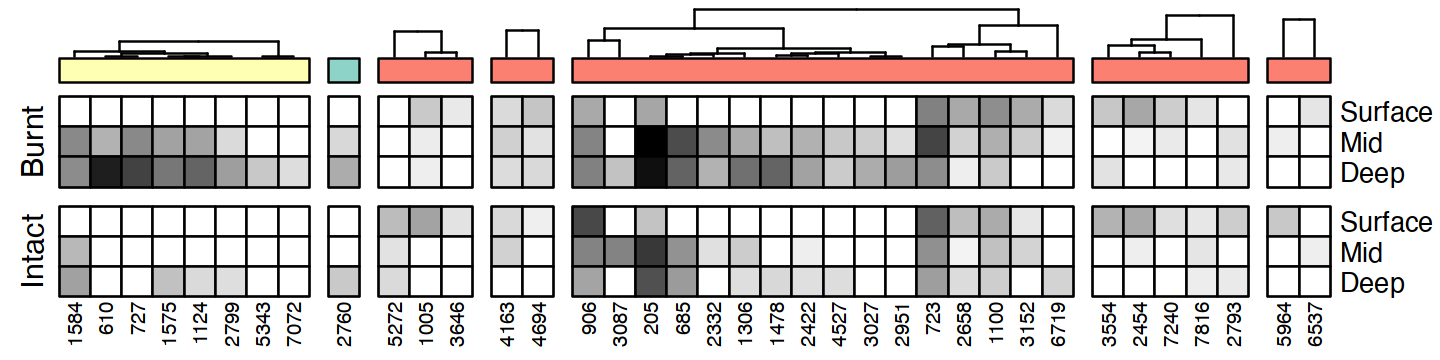

In [11]:
ht_opt$ROW_ANNO_PADDING <- unit(0.1, "cm")
options(repr.plot.width = 12, repr.plot.height = 3)
methanogen_distribution_figure <- draw(
  Heatmap(methanogen_abundance_tab,
    col = c("#ffffff", "#000000"),
    row_gap = unit(4, "mm"),
    column_gap = unit(4, "mm"),
    rect_gp = gpar(col = "black", lwd = 1.5),
    show_heatmap_legend = FALSE,
    show_row_dend = T,
    row_names_side = "right",
    column_dend_gp = gpar(lwd = 1.5),
    heatmap_legend_param = list(
      title = "Z-score",
      legend_direction = "horizontal",
      legend_width = unit(40, "mm"),
      legend_height = unit(55, "mm"),
      labels_gp = gpar(fontsize = 12),
      title_gp = gpar(fontsize = 13, fontface = "bold")
    ),
    border_gp = gpar(col = "black"),
    row_split = factor(rep(letters[1:2], each = 3), levels = letters[1:2]),
    column_split = methanogen_class,
    column_title = NULL,
    cluster_rows = FALSE,
    cluster_column_slices = FALSE,
    cluster_row_slices = FALSE,
    clustering_distance_columns = "spearman",
    row_title = NULL,
    show_column_names = TRUE,
    top_annotation = HeatmapAnnotation(
      pathway = anno_block(
        gp = gpar(lwd = 1.5, fill = c("#ffffb3", "#8dd3c7", rep("#fb8072", 5)))),
      empty = anno_empty(border = FALSE, height = unit(1.6, "mm"))
    ),
    left_annotation = rowAnnotation(
      psf_type = anno_block(
        gp = gpar(col = 0),
        labels = c("Burnt", "Intact"),
        labels_gp = gpar(col = "Black", fontsize = 18)
      )
    )
  ) +
    rowAnnotation(
      labels = anno_text(
        c("Surface", "Mid", "Deep", "Surface", "Mid", "Deep"),
        which = "row",
        gp = gpar(fontsize = 16)
      )
    ),
  heatmap_legend_side = "bottom"
)

In [12]:
## import PICRUST2 results
## ASVs with methanotrophy modules ≥0.75 completeness
btp_ko_methanotrophy_modules <- read.table(
    file.path(data, "5_picrust2", "2020_btp_ko_methanotrophy_modules.tsv"),
    sep = "\t",
    header = TRUE
) %>%
  clean_names %>%
  filter(genome_name %in% pull(btp_nsti, ASV))

In [13]:
## ANOVA
methanogen_abundance_anova <- aov(Abundance ~ psf_type * depth, data = methanogen_abundance)
summary(methanogen_abundance_anova)

               Df Sum Sq Mean Sq F value   Pr(>F)    
psf_type        1  156.8  156.77  16.849 0.000665 ***
depth           2  112.7   56.33   6.055 0.009754 ** 
psf_type:depth  2  146.1   73.03   7.848 0.003541 ** 
Residuals      18  167.5    9.30                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [14]:
## pairwise comparisons
emmeans(methanogen_abundance_anova, pairwise ~ psf_type | depth)$contrasts

depth = 0-5:
 contrast       estimate   SE df t.ratio p.value
 Burnt - Intact    -1.12 2.16 18  -0.520  0.6091

depth = 35-40:
 contrast       estimate   SE df t.ratio p.value
 Burnt - Intact     5.51 2.16 18   2.557  0.0198

depth = 95-100:
 contrast       estimate   SE df t.ratio p.value
 Burnt - Intact    10.94 2.16 18   5.073  0.0001


In [15]:
## methanogen abundance figure
methanogen_abundance_figure <- methanogen_abundance %>%
  ggplot(., aes(x = depth, y = Abundance, color = psf_type)) +
  geom_point(position = position_dodge(width = 0.8), shape = 1, size = 4, stroke = 1.4) +
  geom_signif(
    xmin = c(0.8), 
    xmax = c(1.2), 
    y_position = c(10), 
    annotations = c("ns"), 
    size = 0.5, 
    textsize = 6, 
    vjust = -0.3,
    family = "Helvetica",
    color = "black"
  ) +
  geom_signif(
    xmin = c(1.8, 2.8), 
    xmax = c(2.2, 3.2), 
    y_position = c(16, 19),
    annotations = c("*", "***"), 
    size = 0.5, 
    textsize = 8, 
    vjust = 0.3,
    family = "Helvetica",
    color = "black"
  ) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(
    aspect.ratio = 1,
    legend.position = "none"
  ) +
  scale_y_continuous(limits = c(0, 20)) +
  scale_x_discrete(labels = c("Surface", "Mid", "Deep")) +
  xlab("Depth") +
  ylab("Relative Abundance (%)") +
  guides(shape = guide_legend(title = "Depth")) + 
  scale_color_manual(
    "PSF", 
    values = c("#e66101", "#1a9641"), 
    labels = c("Burnt", "Intact")
  )

In [16]:
## abundance of methanotrophs
methanotroph_abundance <- btp_fire_ps %>%
  subset_taxa(., Kingdom == "Bacteria") %>%
  transform_sample_counts(., function(x) x / sum(x)) %>%
  psmelt %>%
  filter(OTU %in% pull(distinct(btp_ko_methanotrophy_modules, genome_name))) %>%
  group_by(Sample, psf_type, depth) %>%
  reframe(Abundance = round((sum(Abundance) * 100), 2))

In [17]:
## ANOVA
methanotroph_abundance_anova <- aov(Abundance ~ psf_type * depth, data = methanotroph_abundance)
summary(methanotroph_abundance_anova)

               Df Sum Sq Mean Sq F value  Pr(>F)   
psf_type        1  41.92   41.92  11.628 0.00312 **
depth           2  43.73   21.87   6.064 0.00970 **
psf_type:depth  2   8.80    4.40   1.220 0.31850   
Residuals      18  64.90    3.61                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [18]:
## pairwise comparisons
emmeans(methanotroph_abundance_anova, pairwise ~ psf_type | depth)$contrasts

depth = 0-5:
 contrast       estimate   SE df t.ratio p.value
 Burnt - Intact    -0.96 1.34 18  -0.715  0.4838

depth = 35-40:
 contrast       estimate   SE df t.ratio p.value
 Burnt - Intact    -3.76 1.34 18  -2.799  0.0119

depth = 95-100:
 contrast       estimate   SE df t.ratio p.value
 Burnt - Intact    -3.21 1.34 18  -2.393  0.0278


In [19]:
## abundance table for heatmap
methanotroph_abundance_tab <- btp_fire_ps %>%
  subset_taxa(., Kingdom == "Bacteria") %>%
  transform_sample_counts(., function(x) x / sum(x)) %>%
  psmelt %>%
  filter(OTU %in% pull(distinct(btp_ko_methanotrophy_modules, genome_name))) %>%
  group_by(psf_type, depth, OTU, Family) %>%
  reframe(Abundance = sqrt(mean(Abundance))) %>%
  arrange(psf_type, depth, Family) %>%
  group_by(psf_type, depth) %>%
  mutate(group = cur_group_id()) %>%
  ungroup %>%
  select(OTU, group, Abundance) %>% 
  mutate(OTU = parse_number(OTU)) %>%
  pivot_wider(names_from = OTU, values_from = Abundance) %>%
  column_to_rownames("group") %>%
  as.matrix

In [20]:
## extract family labels for heatmap
methanotroph_family <- enframe(colnames(methanotroph_abundance_tab), value = "ASV", name = NULL) %>%
  mutate(ASV = paste0("ASV_", ASV)) %>%
  inner_join(
    tax_table(btp_fire_ps) %>%
      data.frame() %>%
      rownames_to_column("ASV")
  ) %>%
  mutate(ASV = parse_number(ASV)) %>%
  mutate(Family = factor(Family)) %>%
  pull(Family)

Joining with `by = join_by(ASV)`


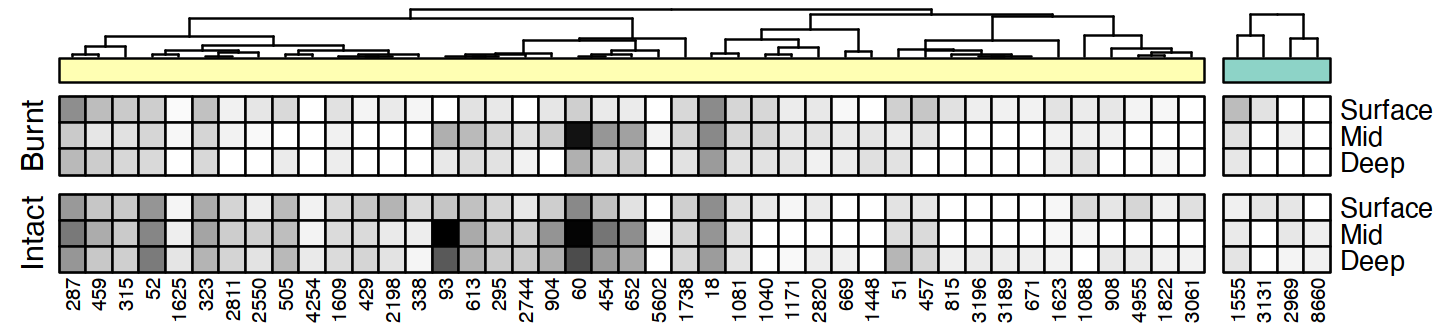

In [21]:
ht_opt$ROW_ANNO_PADDING <- unit(0.1, "cm")
options(repr.plot.width = 12, repr.plot.height = 2.8)
methanotroph_distribution_figure <- draw(
  Heatmap(methanotroph_abundance_tab,
    col = c("#ffffff", "#000000"),
    row_gap = unit(4, "mm"),
    column_gap = unit(4, "mm"),
    rect_gp = gpar(col = "black", lwd = 1.5),
    show_heatmap_legend = FALSE,
    show_row_dend = T,
    row_names_side = "right",
    column_dend_gp = gpar(lwd = 1.5),
    heatmap_legend_param = list(
      title = "Z-score",
      legend_direction = "horizontal",
      legend_width = unit(40, "mm"),
      legend_height = unit(55, "mm"),
      labels_gp = gpar(fontsize = 12),
      title_gp = gpar(fontsize = 13, fontface = "bold")
    ),
    border_gp = gpar(col = "black"),
    row_split = factor(rep(letters[1:2], each = 3), levels = letters[1:2]),
    column_split = methanotroph_family,
    column_title = NULL,
    cluster_rows = FALSE,
    cluster_column_slices = FALSE,
    cluster_row_slices = FALSE,
    clustering_distance_columns = "spearman",
    row_title = NULL,
    show_column_names = TRUE,
    top_annotation = HeatmapAnnotation(
      pathway = anno_block(
        gp = gpar(lwd = 1.5, fill = c("#ffffb3", "#8dd3c7", rep("#fb8072", 5)))),
      empty = anno_empty(border = FALSE, height = unit(1.6, "mm"))
    ),
    left_annotation = rowAnnotation(
      psf_type = anno_block(
        gp = gpar(col = 0),
        labels = c("Burnt", "Intact"),
        labels_gp = gpar(col = "Black", fontsize = 18)
      )
    )
  ) +
    rowAnnotation(
      labels = anno_text(
        c("Surface", "Mid", "Deep", "Surface", "Mid", "Deep"),
        which = "row",
        gp = gpar(fontsize = 16)
      )
    ),
  heatmap_legend_side = "bottom"
)

In [22]:
## methanogen abundance figure
methanotroph_abundance_figure <- methanotroph_abundance %>%
  ggplot(., aes(x = depth, y = Abundance, color = psf_type)) +
  geom_point(position = position_dodge(width = 0.8), shape = 1, size = 4, stroke = 1.4) +
  geom_signif(
    xmin = c(0.8), 
    xmax = c(1.2), 
    y_position = c(7), 
    annotations = c("ns"), 
    size = 0.5, 
    textsize = 6, 
    vjust = -0.3,
    family = "Helvetica",
    color = "black"
  ) +
  geom_signif(
    xmin = c(1.8, 2.8), 
    xmax = c(2.2, 3.2), 
    y_position = c(13, 8),
    annotations = c("*", "*"), 
    size = 0.5, 
    textsize = 8, 
    vjust = 0.3,
    family = "Helvetica",
    color = "black"
  ) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(
    aspect.ratio = 1,
    legend.position = "none"
  ) +
  scale_y_continuous(limits = c(0, 20)) +
  scale_x_discrete(labels = c("Surface", "Mid", "Deep")) +
  xlab("Depth") +
  ylab("Relative Abundance (%)") +
  guides(shape = guide_legend(title = "Depth")) + 
  scale_color_manual(
    "PSF", 
    values = c("#e66101", "#1a9641"), 
    labels = c("Burnt", "Intact")
  )

In [23]:
## methanotroph:methanogen ratio
methanotroph_methanogen_ratio <- btp_fire_ps %>%
  transform_sample_counts(., function(x) x / sum(x)) %>%
  psmelt() %>%
  filter(OTU %in% c(
    pull(distinct(btp_ko_methanotrophy_modules, genome_name)),
    pull(distinct(btp_ko_methanogenesis_modules, genome_name))
  )) %>%
  group_by(Sample, Kingdom, psf_type, depth) %>%
  reframe(Abundance = sum(Abundance)) %>%
  pivot_wider(names_from = Kingdom, values_from = Abundance) %>%
  filter(Archaea > 0) %>%
  mutate(ratio = round((Bacteria / Archaea), 2))

In [24]:
## ANOVA
methanotroph_methanogen_ratio_anova <- aov(ratio ~ psf_type * depth, data = methanotroph_methanogen_ratio)
summary(methanotroph_methanogen_ratio_anova)

               Df Sum Sq Mean Sq F value  Pr(>F)   
psf_type        1  373.0   373.0  13.215 0.00244 **
depth           2   86.0    43.0   1.523 0.24984   
psf_type:depth  2  138.1    69.1   2.446 0.12036   
Residuals      15  423.4    28.2                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [25]:
## pairwise comparisons
emmeans(methanotroph_methanogen_ratio_anova, pairwise ~ psf_type | depth)$contrasts

depth = 0-5:
 contrast       estimate   SE df t.ratio p.value
 Burnt - Intact    -0.24 4.60 15  -0.052  0.9591

depth = 35-40:
 contrast       estimate   SE df t.ratio p.value
 Burnt - Intact   -13.31 3.76 15  -3.544  0.0029

depth = 95-100:
 contrast       estimate   SE df t.ratio p.value
 Burnt - Intact    -9.19 4.06 15  -2.266  0.0387


In [26]:
## methanogen abundance figure
ratio_figure <- methanotroph_methanogen_ratio %>%
  ggplot(., aes(x = depth, y = ratio, color = psf_type)) +
  geom_point(position = position_dodge(width = 0.8), shape = 1, size = 4, stroke = 1.4) +
  geom_signif(
    xmin = c(0.8), 
    xmax = c(1.2), 
    y_position = c(16), 
    annotations = c("ns"), 
    size = 0.5, 
    textsize = 6, 
    vjust = -0.3,
    family = "Helvetica",
    color = "black"
  ) +
  geom_signif(
    xmin = c(1.8, 2.8), 
    xmax = c(2.2, 3.2), 
    y_position = c(35, 18),
    annotations = c("**", "*"), 
    size = 0.5, 
    textsize = 8, 
    vjust = 0.3,
    family = "Helvetica",
    color = "black"
  ) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(
    aspect.ratio = 1,
    legend.position = "none",
    axis.title.y = element_text(size = 15.5),
  ) +
  scale_y_continuous(limits = c(0, 40)) +
  scale_x_discrete(labels = c("Surface", "Mid", "Deep")) +
  xlab("Depth") +
  ylab("Methanotrophs:Methanogens") +
  guides(shape = guide_legend(title = "Depth")) + 
  scale_color_manual(
    "PSF", 
    values = c("#e66101", "#1a9641"), 
    labels = c("Burnt", "Intact")
  )

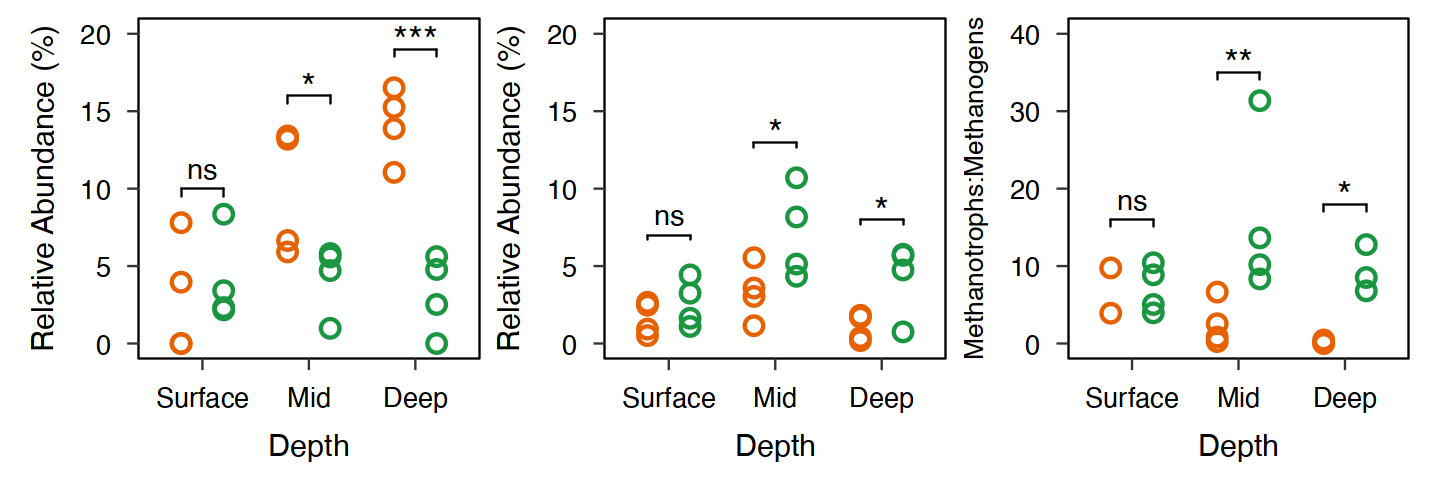

In [27]:
## compose plot
options(repr.plot.width = 12, repr.plot.height = 4)
methanogen_abundance_figure + methanotroph_abundance_figure + ratio_figure

In [28]:
## import metagenome marker profiles
mcra_profile <- read.csv(file.path(data, "7_metagenomes", "2020_btp_mcrA_graftM.csv"))
rpsj_profile <- read.csv(file.path(data, "7_metagenomes", "2020_btp_rpsJ_graftM.csv"))
pmoa_profile <- read.csv(file.path(data, "7_metagenomes", "2020_btp_pmoA_graftM.csv"))

In [29]:
## mcrA aggregated counts
mcra_counts <- mcra_profile %>%
  pivot_longer(-c("MSV", "consensus_lineage"), names_to = "sample", values_to = "counts") %>%
  group_by(sample) %>%
  reframe(mcra_counts = sum(counts))

In [30]:
## rpsJ aggregated counts for archaea
rpsj_counts_archaea <- rpsj_profile %>%
  pivot_longer(-c("MSV", "consensus_lineage"), names_to = "sample", values_to = "counts") %>%
  filter(str_detect(consensus_lineage, "Archaea")) %>%
  group_by(sample) %>%
  reframe(rpsj_counts = sum(counts))

In [31]:
## rpsJ aggregated counts for bacteria
rpsj_counts_bacteria <- rpsj_profile %>%
  pivot_longer(-c("MSV", "consensus_lineage"), names_to = "sample", values_to = "counts") %>%
  filter(str_detect(consensus_lineage, "Bacteria")) %>%
  group_by(sample) %>%
  reframe(rpsj_counts = sum(counts))

In [32]:
## pmoA aggregated counts
pmoa_counts <- pmoa_profile %>%
  pivot_longer(-c("MSV", "consensus_lineage"), names_to = "sample", values_to = "counts") %>%
  filter(str_detect(consensus_lineage, "pmoA")) %>%
  group_by(sample) %>%
  reframe(pmoa_counts = sum(counts))

In [181]:
## plot correlation between mcrA and predicted methanogen counts
methanogens_predicted_sequenced_correlation_figure <- inner_join(mcra_counts, rpsj_counts_archaea) %>% 
  inner_join(methanogen_abundance, by = c("sample" = "Sample")) %>%
  mutate(norm_mcra_counts = (mcra_counts / rpsj_counts) * 100) %>%
  ggplot(., aes(x = Abundance, y = norm_mcra_counts)) +
  geom_point(size = 5, aes(color = psf_type, shape = depth), stroke = 1.3) +
  scale_shape_manual("Depth", values = c(0, 1, 3), labels = c("Surface", "Mid", "Deep")) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(aspect.ratio = 1, legend.position = "none") +
  geom_smooth(method = "lm", alpha = 0.15) +
  scale_color_manual("Fire", values = c("#e66101", "#1a9641"), labels = c("Burnt", "Intact")) +
  xlab("Predicted Relative Abundance (%)") +
  ylab("Sequenced Relative Abundance (%)") +
  annotate("text", x = 2.5, y = 53, label = "rho = 0.88", size = 7) +
  annotate("text", x = 3.2, y = 48, label = 'italic("p") < 0.001', size = 7, parse = TRUE)

Joining with `by = join_by(sample)`


In [182]:
## plot correlation between pmoA and predicted methanotroph counts
methanotrophs_predicted_sequenced_correlation_figure <- inner_join(pmoa_counts, rpsj_counts_bacteria) %>% 
  inner_join(methanotroph_abundance, by = c("sample" = "Sample")) %>%
  mutate(norm_pmoa_counts = (pmoa_counts / rpsj_counts) * 100) %>%
  ggplot(., aes(x = Abundance, y = norm_pmoa_counts)) +
  geom_point(size = 5, aes(color = psf_type, shape = depth), stroke = 1.3) +
  scale_shape_manual("Depth", values = c(0, 1, 3), labels = c("Surface", "Mid", "Deep")) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(legend.spacing = unit(1, "cm")) +
  geom_smooth(method = "lm", alpha = 0.15) +
  scale_color_manual("Fire", values = c("#e66101", "#1a9641"), labels = c("Burnt", "Intact")) +
  xlab("Predicted Relative Abundance (%)") +
  ylab("Sequenced Relative Abundance (%)") +
  annotate("text", x = 1.7, y = 6.5, label = "rho = 0.63", size = 7) +
  annotate("text", x = 1.1, y = 6, label = "italic(p)", size = 7, parse = TRUE) +
  annotate("text", x = 2.2, y = 6.05, label = "= 0.02", size = 7)

Joining with `by = join_by(sample)`


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


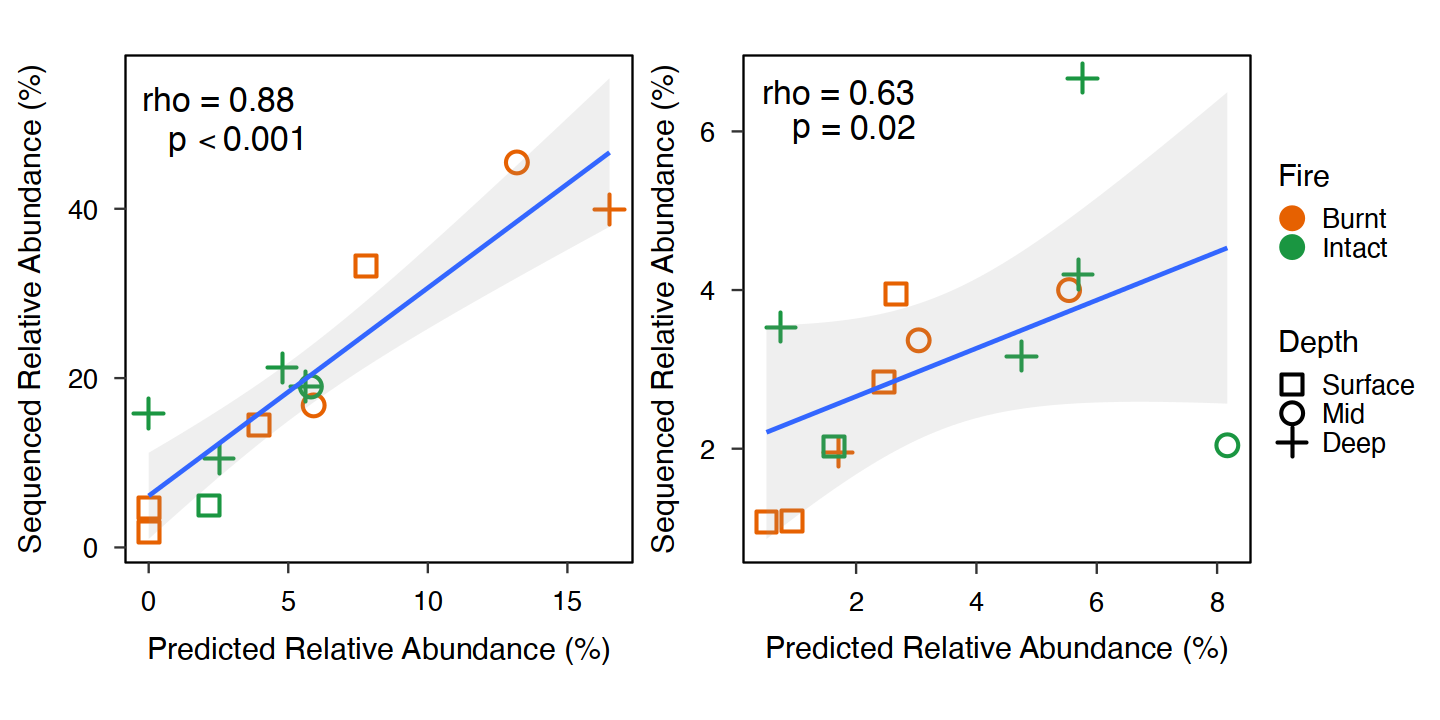

In [183]:
## compose plot
options(repr.plot.width = 12, repr.plot.height = 6)
methanogens_predicted_sequenced_correlation_figure + methanotrophs_predicted_sequenced_correlation_figure